In [61]:
import pickle
import pandas as pd

In [160]:
df = pd.read_csv("datasets/ssnce.csv.gz")
with open("datasets/ssnce.pkl", "rb") as f:
    feats = pickle.load(f)

In [161]:
def _get_feat(row):
    index = int((row["min"] + row["max"]) / 2.0 * 16000) // 320
    f = feats[row.audio]
    if index >= len(f):
        index = len(f) - 1
    return f[index]

df["feat"] = df.apply(_get_feat, axis=1)

/home/kwanghec/acoustic_units/envs/lib/python3.11/site-packages/umap/umap_.py:1895: UserWarning: gradient function is not yet implemented for dot distance metric; inverse_transform will be unavailable
  warn(


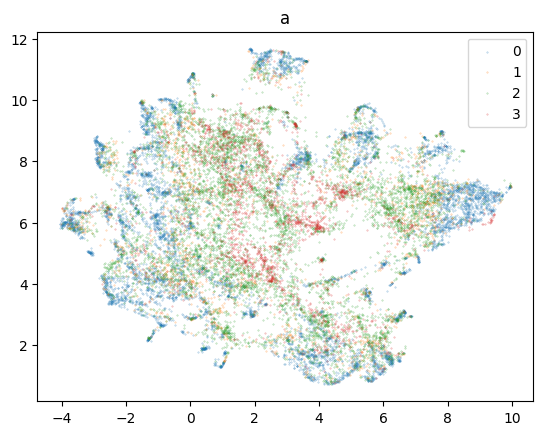

/home/kwanghec/acoustic_units/envs/lib/python3.11/site-packages/umap/umap_.py:1895: UserWarning: gradient function is not yet implemented for dot distance metric; inverse_transform will be unavailable
  warn(


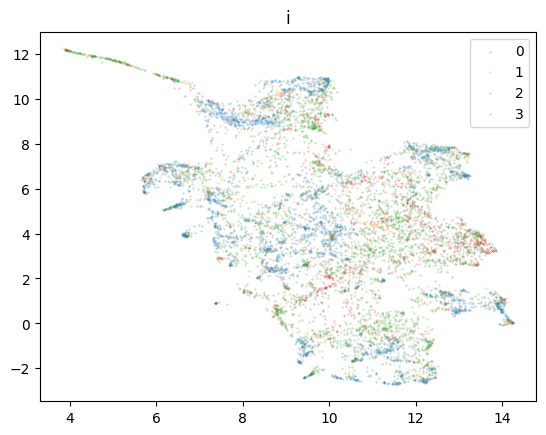

/home/kwanghec/acoustic_units/envs/lib/python3.11/site-packages/umap/umap_.py:1895: UserWarning: gradient function is not yet implemented for dot distance metric; inverse_transform will be unavailable
  warn(


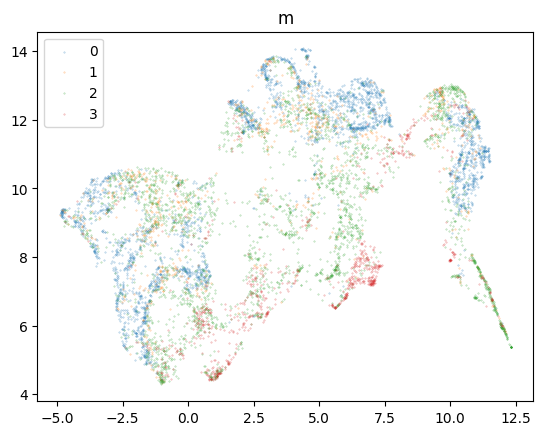

/home/kwanghec/acoustic_units/envs/lib/python3.11/site-packages/umap/umap_.py:1895: UserWarning: gradient function is not yet implemented for dot distance metric; inverse_transform will be unavailable
  warn(


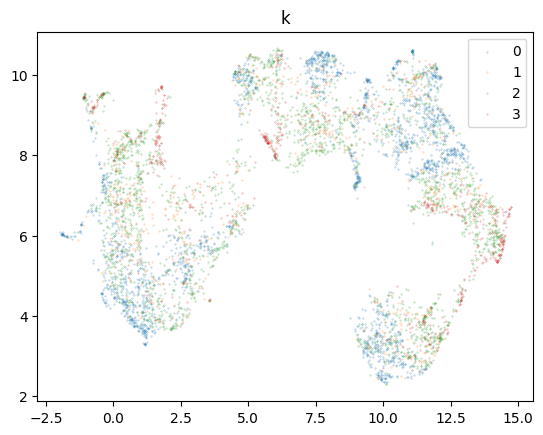

/home/kwanghec/acoustic_units/envs/lib/python3.11/site-packages/umap/umap_.py:1895: UserWarning: gradient function is not yet implemented for dot distance metric; inverse_transform will be unavailable
  warn(


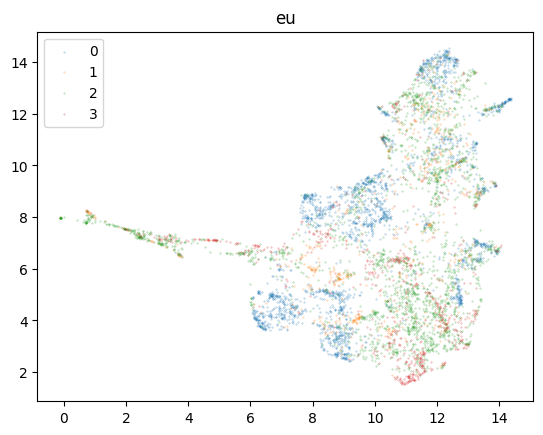

In [163]:
import umap
import matplotlib.pyplot as plt

for phone, _ in df.phone.value_counts().head(6).tail(5).items():
    reducer = umap.UMAP(metric="dot")
    _df = df[df.phone == phone]
    embs = np.stack(_df.feat.tolist())
    u = reducer.fit_transform(embs)

    plt.figure()
    plt.title(phone)
    for label in _df.label.unique():
        mask = (_df.label == label)
        plt.scatter(u[mask, 0], u[mask, 1], c=f"C{label}", label=label, s=0.1, alpha=0.5)
    plt.legend()
    plt.show()

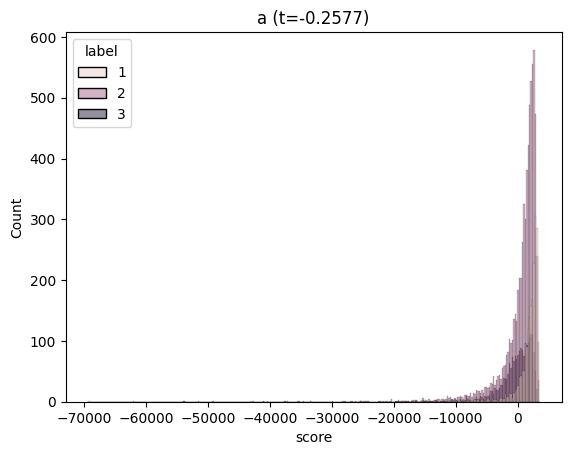

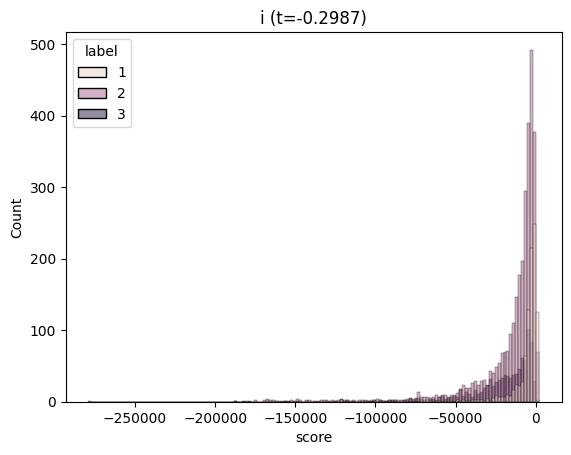

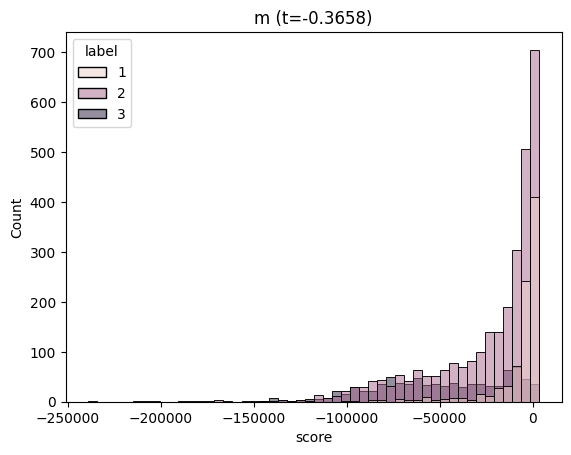

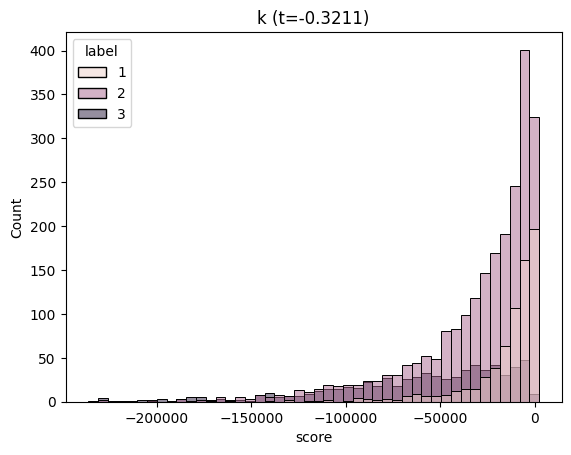

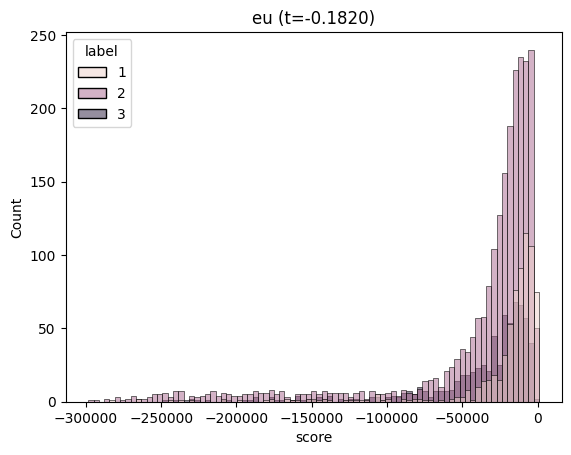

In [166]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
from scipy.stats import kendalltau

for phone, _ in df.phone.value_counts().head(6).tail(5).items():
    _df = df[df.phone == phone]
    _df_healthy = _df[_df.label == 0]
    embs = np.stack(_df_healthy.feat.tolist())
    embs /= np.linalg.norm(embs, axis=1).reshape(-1, 1)
    gm = GaussianMixture(n_components=4, random_state=0).fit(embs)

    _df_dys = _df[_df.label != 0]
    embs = np.stack(_df_dys.feat.tolist())
    embs /= np.linalg.norm(embs, axis=1).reshape(-1, 1)
    scores = gm.score_samples(embs)
    t = kendalltau(scores, _df_dys.label).statistic

    ax = sns.histplot(data=pd.DataFrame({"label": _df_dys.label, "score": scores}), x="score", hue="label")
    ax.set_title(f"{phone} (t={t:.4f})")
    plt.show()